In [2]:
import sys
sys.path.append("../../XLEMOO")

In [3]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier

NameError: name 'List' is not defined

In [169]:
def plot_best_fitnesses(generations: List[PastGeneration]) -> None:
    best_values = np.array([np.min(gen.fitness_fun_values) for gen in generations])
    plt.plot(np.arange(best_values.shape[0]), best_values)
    
    return

def plot_mean_fitnesses(generations: List[PastGeneration]) -> None:
    mean_values = np.array([np.mean(gen.fitness_fun_values) for gen in generations])
    plt.plot(np.arange(mean_values.shape[0]), mean_values)
    
    return

def plot_std_fitnesses(generations: List[PastGeneration]) -> None:
    std_values = np.array([np.std(gen.fitness_fun_values) for gen in generations])
    plt.plot(np.arange(std_values.shape[0]), std_values)
    
    return

## Define problem

In [163]:
n_objectives = 8
n_variables = 11
problem = test_problem_builder("DTLZ7", n_variables, n_objectives)
# problem = river_pollution_problem()

## Setting model parameters

In [186]:
nadir = np.ones(n_objectives)
ideal = np.zeros(n_objectives)
# ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
# nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
ref_point = np.array([0.1]*10)
# fitness_fun = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

fitness_fun = naive_sum

lem_params = LEMParams(
    n_total_iterations=100,
    n_ea_gen_per_iter=10,
    n_ml_gen_per_iter=1,
    use_darwin=True,
    use_ml=False,
    fitness_indicator=fitness_fun,
    ml_probe = 5,
    ml_threshold = 0.999,
    darwin_probe = 5,
    darwin_threshold = 0.999
)

ea_params = EAParams(
    population_size=100,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    selection_op=TournamentSelection(None, tournament_size=2),
    population_init_design="RandomDesign"
)

# ml = DecisionTreeClassifier(random_state=0)
ml = DecisionTreeClassifier()
ml_params = MLParams(
    H_split=0.2,
    L_split=0.2,
    ml_model=ml,
    ml_fitness=fitness_fun
)

## Setup LEMOO model

In [187]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [188]:
lemoo.run()

{'darwin_mode': 52, 'learning_mode': 0}

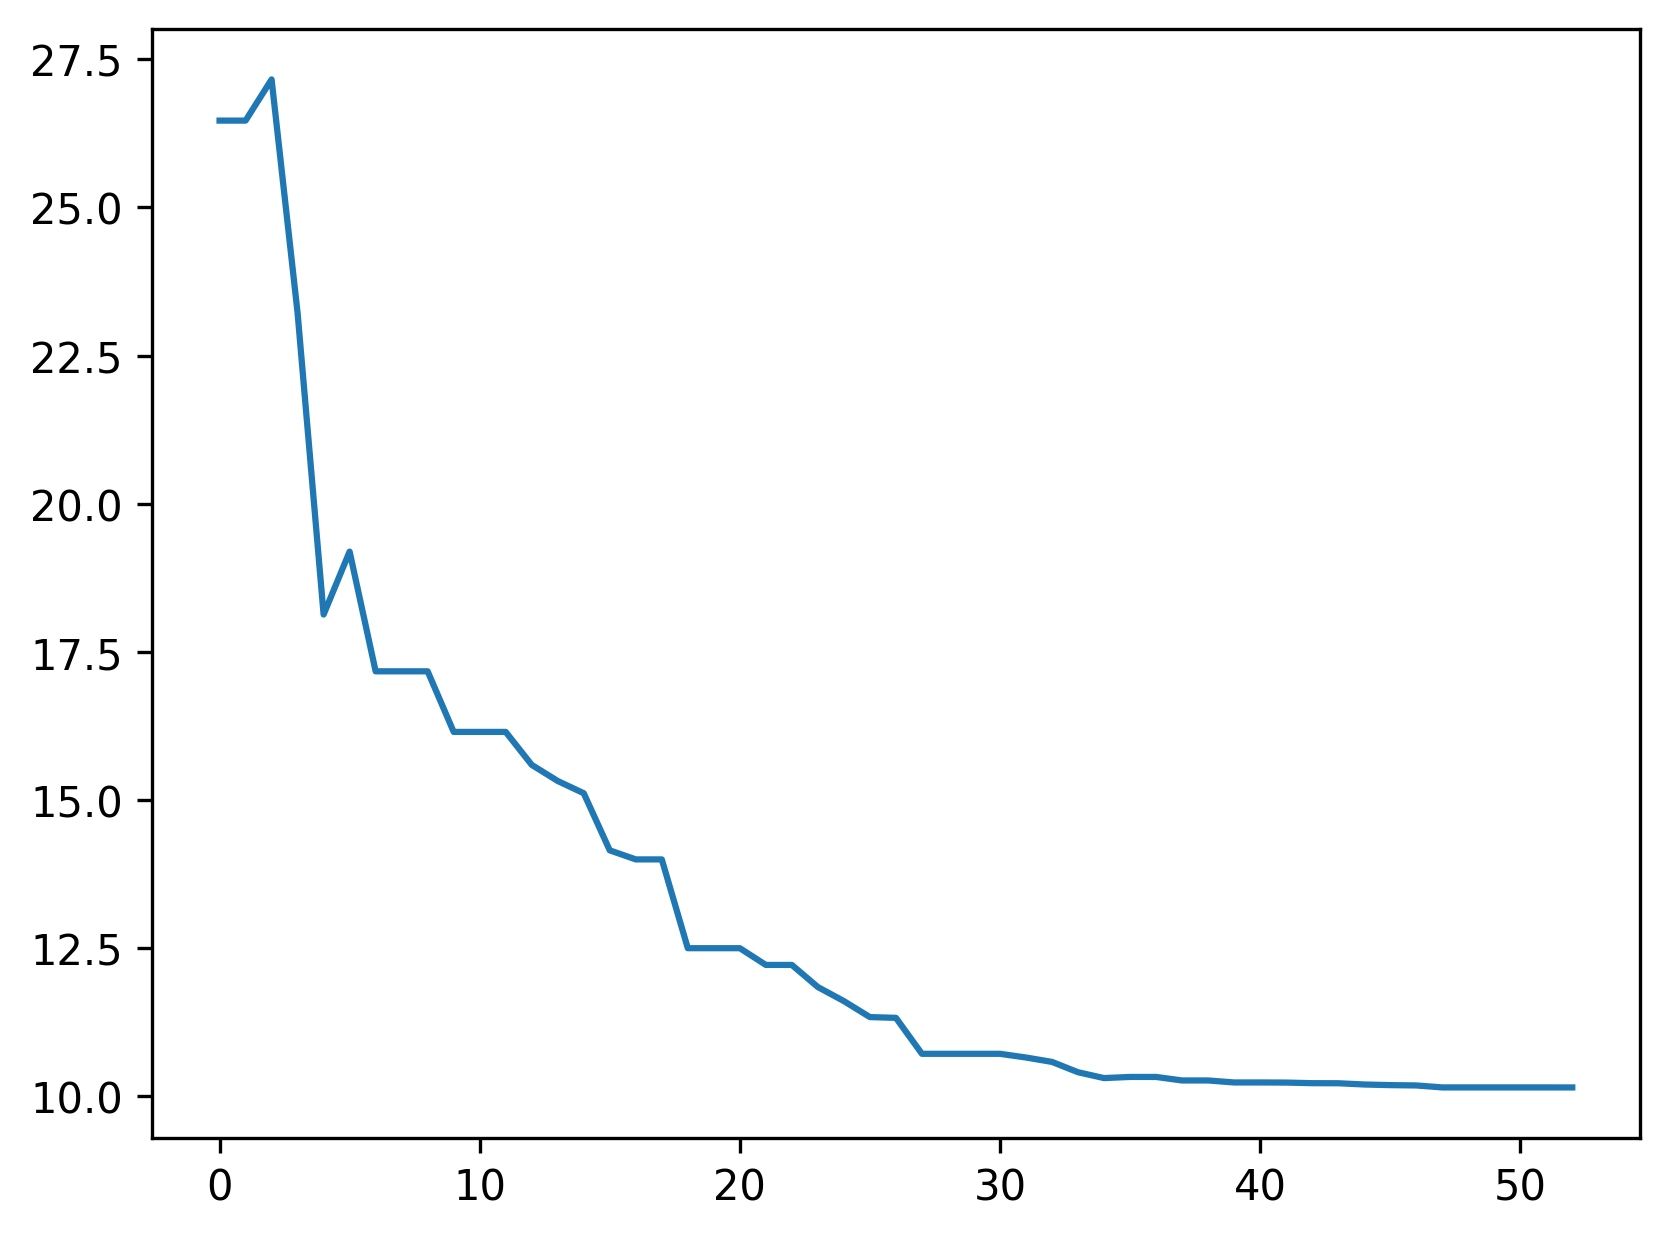

In [189]:
plot_best_fitnesses(lemoo._generation_history)

[[9.99979820e-01 4.90684804e-01 5.19368158e-01]
 [9.99979820e-01 4.90684804e-01 5.19368158e-01]
 [9.99979820e-01 4.90684804e-01 5.19368158e-01]
 [9.99979820e-01 4.90684804e-01 5.19368158e-01]
 [1.29422964e-04 5.17878262e-01 4.99323405e-01]
 [4.21120409e-04 4.93645551e-01 4.75264721e-01]
 [1.20894647e-03 5.15494318e-01 5.01655669e-01]
 [6.87467278e-04 4.78951767e-01 5.26955400e-01]
 [9.99344542e-01 4.99927674e-01 4.55677252e-01]
 [1.84603682e-03 5.03898771e-01 4.84952838e-01]
 [2.32128015e-03 4.80942694e-01 5.03040421e-01]
 [1.19967567e-04 5.15361445e-01 5.21067542e-01]
 [2.07655434e-03 5.08175201e-01 5.06362523e-01]
 [2.27559726e-05 4.49535723e-01 4.93836165e-01]
 [9.98630012e-01 4.90831752e-01 4.66748168e-01]
 [1.00000000e+00 4.77434858e-01 4.62927436e-01]
 [9.99977456e-01 5.13144030e-01 4.88567151e-01]
 [1.53061920e-04 5.30116042e-01 4.99721111e-01]
 [3.51197464e-05 4.98322441e-01 4.88172178e-01]
 [1.16570148e-03 4.77534432e-01 4.79293442e-01]
 [1.35665007e-04 4.80982564e-01 5.057179

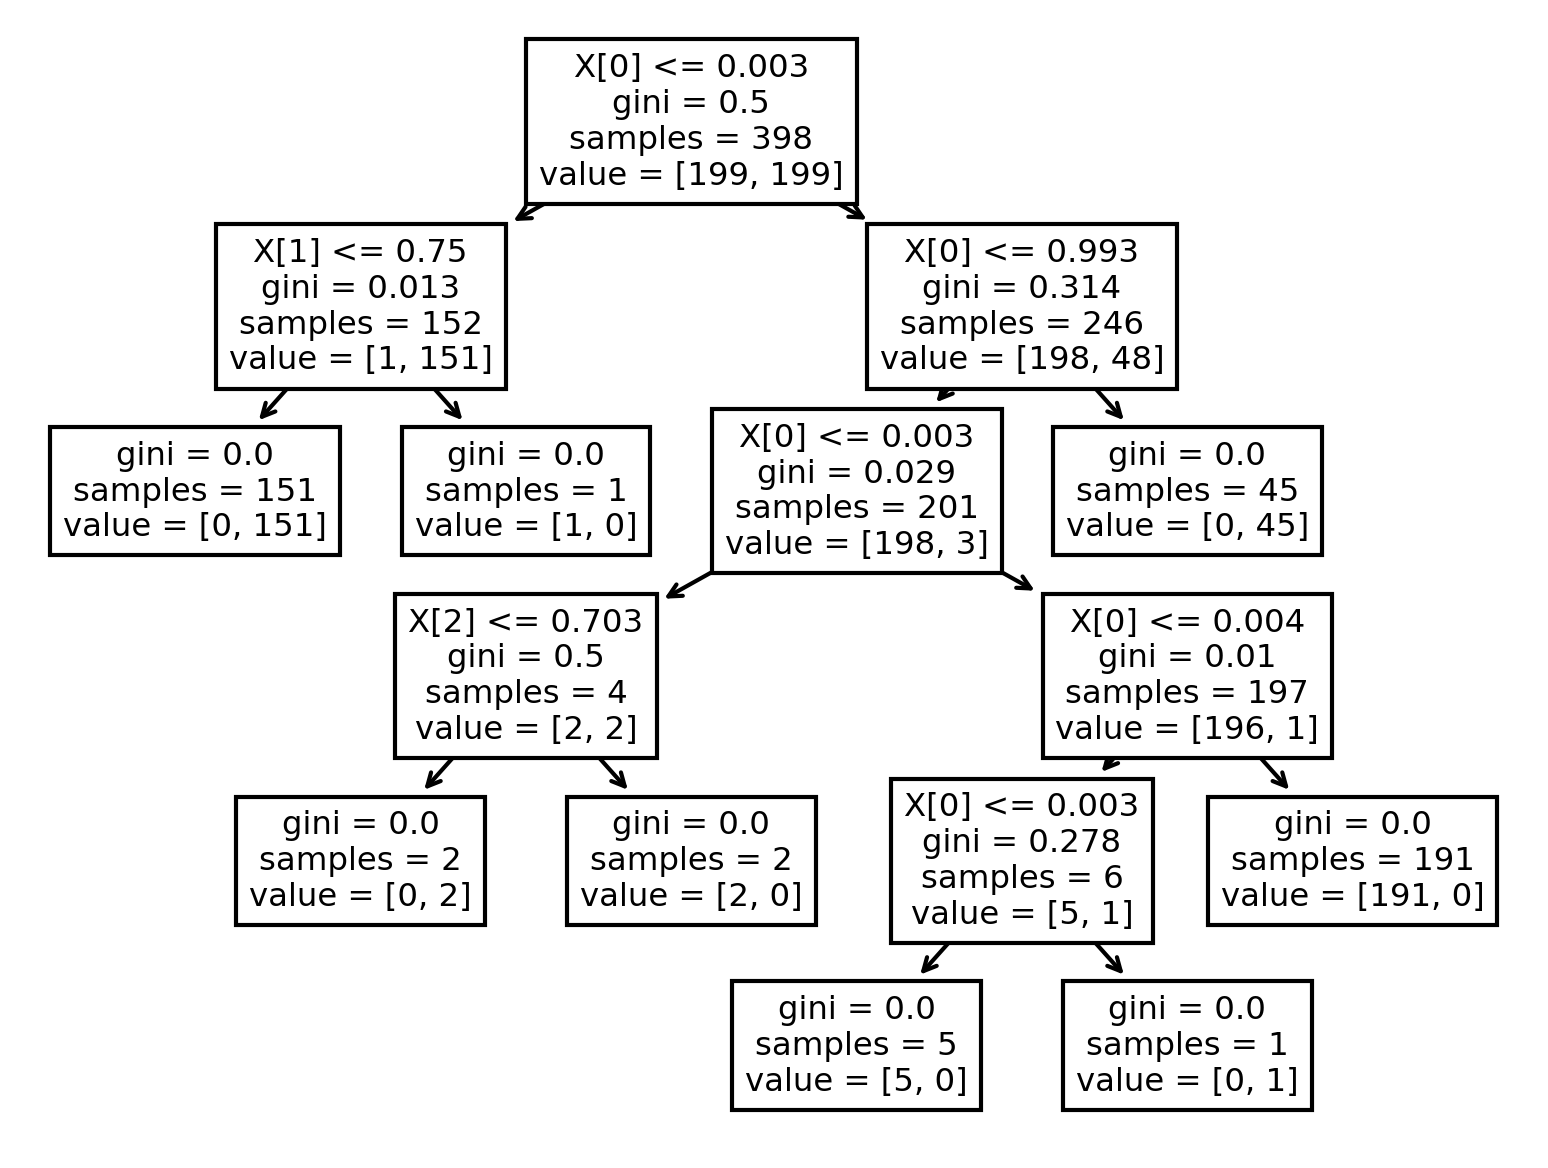

In [103]:
tree.plot_tree(lemoo.current_ml_model);
print(lemoo._generation_history[-1].individuals)